In [1]:
import os.path
import math
import re
import tensorflow as tf
import numpy as np
import facenet
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.lines as lines
%matplotlib inline

In [2]:
def get_model_filenames(model_dir):
    files = os.listdir(model_dir)
    meta_files = [s for s in files if s.endswith('.meta')]
    if len(meta_files)==0:
        raise ValueError('No meta file found in the model directory (%s)' % model_dir)
    elif len(meta_files)>1:
        raise ValueError('There should not be more than one meta file in the model directory (%s)' % model_dir)
    meta_file = meta_files[0]
    meta_files = [s for s in files if '.ckpt' in s]
    max_step = -1
    for f in files:
        step_str = re.match(r'(^model-[\w\- ]+.ckpt-(\d+))', f)
        if step_str is not None and len(step_str.groups())>=2:
            step = int(step_str.groups()[1])
            if step > max_step:
                max_step = step
                ckpt_file = step_str.groups()[0]
    return meta_file, ckpt_file

def load_model(model, sess):
    model_exp = os.path.expanduser(model)
    print('Model directory: %s' % model_exp)
    meta_file, ckpt_file = get_model_filenames(model_exp)

    print('Metagraph file: %s' % meta_file)
    print('Checkpoint file: %s' % ckpt_file)

    saver = tf.train.import_meta_graph(os.path.join(model_exp, meta_file))
    saver.restore(sess, os.path.join(model_exp, ckpt_file))

In [3]:
def forward(paths, batch_size):
    nrof_images = len(paths)
    nrof_batches = int(math.ceil(1.0*nrof_images / batch_size))
    emb_array = np.zeros((nrof_images, embedding_size))

    for i in range(nrof_batches):    
        start_index = i*batch_size
        end_index = min((i+1)*batch_size, nrof_images)
        paths_batch = paths[start_index:end_index]
        images = facenet.load_data(paths_batch, False, False, image_size)
        feed_dict = { images_placeholder:images, phase_train_placeholder:False }
        emb_array[start_index:end_index,:] = sess.run(embeddings, feed_dict=feed_dict)    
        print("batch number:", i)
    print("Complete")
    
    return emb_array

def printDistance(emb_array, label_list, end=10):
    threshold = 1.0
    lng = len(emb_array[:end])
    print('Distance matrix')
    print('    ', end='')
    for i in range(lng):
        print('    %3d     ' % i, end='')
    print('')
    for i in range(lng):
        print('%1d  ' % i, end='')
        for j in range(lng):
            dist = np.linalg.norm(emb_array[i,:] - emb_array[j,:])
            print('  %1.4f' % dist, end='')
            if (label_list[i] == label_list[j]) and (dist <= threshold):
                print("(TP)", end='')
            elif (label_list[i] != label_list[j]) and (dist > threshold):
                print("(TN)", end='')
            elif (label_list[i] == label_list[j]) and (dist > threshold):
                print("\033[93m(FN)\033[0m", end='')
            elif (label_list[i] != label_list[j]) and (dist <= threshold):
                print("\033[93m(FP)\033[0m", end='')
        print('')
        
def printData(labels, paths, number):
    for i in range(number):
        if i > 0 and labels[i] != labels[i-1]:
            print('')
        print('{0:3d} {1:3d}   {2:s}'.format(i, labels[i], paths[i].split("\\")[1]))
        # print('{0:3d}   {1:s}'.format(labels[i], paths[i].split("\\")[1]))
        
def PCAtransform(emb_array, n_components = 10):
    pca = PCA(n_components, whiten=True)
    pca.fit(emb_array)
    return pca.transform(emb_array), pca

def splitTrainTest(data_set, percent_train):
    paths, labels_list = facenet.get_image_paths_and_labels(data_set)
    
    lng = len(paths)
    lng_train = int(lng * percent_train / 100);
    lng_test = lng - lng_train
    
    train_paths = paths[0:lng_train]
    test_paths = paths[lng_train:]
    
    train_labels = labels_list[0:lng_train]
    test_labels = labels_list[lng_train:]
    
    return train_paths, train_labels, test_paths, test_labels

def trainFisher(emb_array, y):
    emb_del = np.empty_like(emb_array)
    np.copyto(emb_del, emb_array)
    
    emb_array = np.vstack((emb_array, y))
    
    # y = emb_array[sample_number]
    # emb_del = np.delete(emb_array, (sample_number), axis=0)
    
    E = np.linalg.inv(np.cov(emb_array.T))
    D = (y - (1 / (len(emb_array) - 1) * np.sum(emb_del)))
    
    w = np.dot(E, D)
    c = np.dot(w / np.linalg.norm(w), y)
    
    return c, w

def trainFisherWithNum(emb_array, sample_number):    
    y = emb_array[sample_number]
    emb_del = np.delete(emb_array, (sample_number), axis=0)
    
    E = np.linalg.inv(np.cov(emb_array.T))
    D = (y - (1 / (len(emb_array) - 1) * np.sum(emb_del)))
    
    w = np.dot(E, D)
    c = np.dot(w / np.linalg.norm(w), y)
    
    return c, w    

def Fisher(w, c, sample):
    return np.dot(w / np.linalg.norm(w), sample) - c

In [4]:
sess = tf.Session()

In [5]:
data_set = facenet.get_dataset("../../datasets/lfw/lfw_mtcnnpy_160/")

In [6]:
train_paths, train_labels, test_paths, test_labels = splitTrainTest(data_set, 100)

In [7]:
load_model("20170511-185253", sess)

Model directory: 20170511-185253
Metagraph file: model-20170511-185253.meta
Checkpoint file: model-20170511-185253.ckpt-80000
'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from 20170511-185253\model-20170511-185253.ckpt-80000


In [8]:
images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")

image_size = 160
embedding_size = embeddings.get_shape()[1]

In [9]:
emb_array = forward(train_paths, 100) # 100 means 100 mini-batches

batch number: 0
batch number: 1
batch number: 2
batch number: 3
batch number: 4
batch number: 5
batch number: 6
batch number: 7
batch number: 8
batch number: 9
batch number: 10
batch number: 11
batch number: 12
batch number: 13
batch number: 14
batch number: 15
batch number: 16
batch number: 17
batch number: 18
batch number: 19
batch number: 20
batch number: 21
batch number: 22
batch number: 23
batch number: 24
batch number: 25
batch number: 26
batch number: 27
batch number: 28
batch number: 29
batch number: 30
batch number: 31
batch number: 32
batch number: 33
batch number: 34
batch number: 35
batch number: 36
batch number: 37
batch number: 38
batch number: 39
batch number: 40
batch number: 41
batch number: 42
batch number: 43
batch number: 44
batch number: 45
batch number: 46
batch number: 47
batch number: 48
batch number: 49
batch number: 50
batch number: 51
batch number: 52
batch number: 53
batch number: 54
batch number: 55
batch number: 56
batch number: 57
batch number: 58
batch n

In [10]:
# t = TSNE(n_components=2).fit_transform(emb_array)

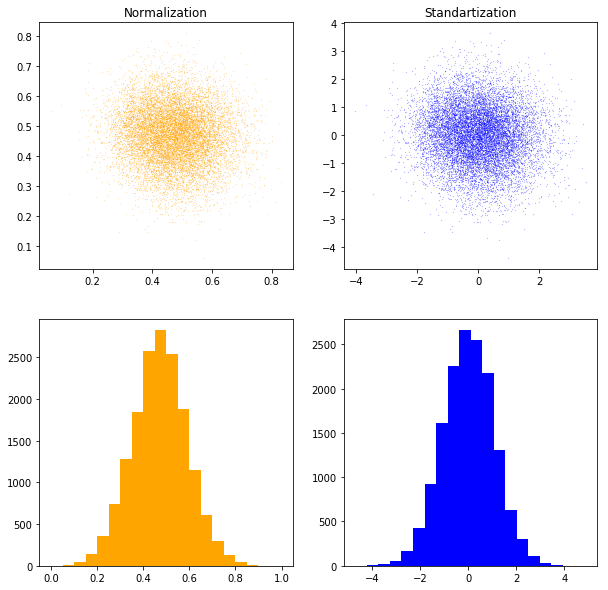

In [91]:
t = emb_array
w1 = 0
w2 = 1

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
s_ = 0.01

# Centering
tc = t - np.mean(t, axis=0)
#ax1.scatter(tc[:, 0], tc[:, 1], c="r", s=0.01)

# Normalization
tn = (tc - tc.min()) / (tc.max() - tc.min())
ax1.scatter(tn[:, w1], tn[:, w2], c="orange", s=s_)
ax1.set_title("Normalization")

# Standartization
ts = tc / tc.std(axis=0)
ax2.scatter(ts[:, w1], ts[:, w2], c="b", s=s_)
ax2.set_title("Standartization")

# Histograms
n, bins, rectangles = ax3.hist(tn, bins=20, facecolor="orange", histtype="stepfilled")
n, bins, rectangles = ax4.hist(ts, bins=20, facecolor="blue", histtype="stepfilled")

plt.savefig('difference.png')

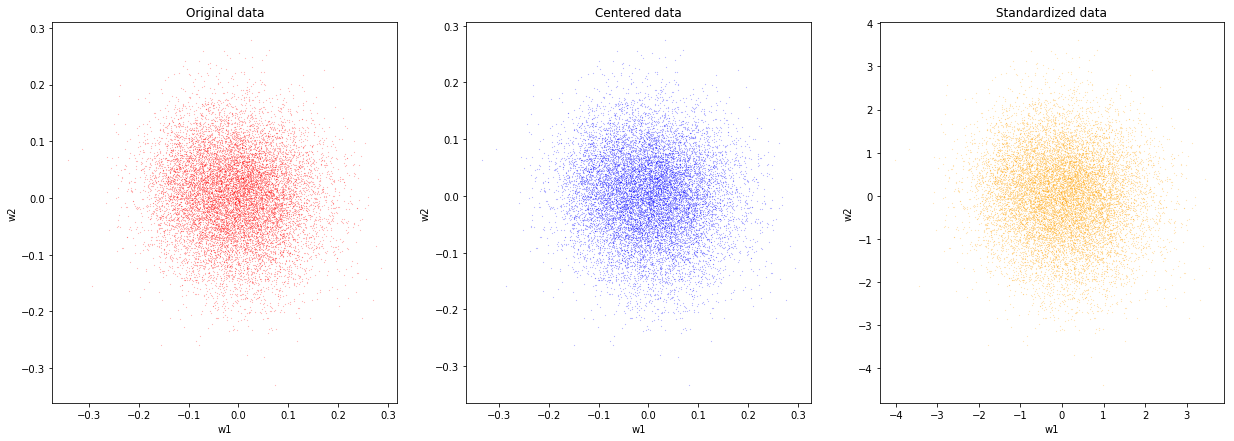

In [92]:
fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(21,7))

# Original data
ax1.set_title("Original data")
ax1.scatter(t[:, w1], t[:, w2], c="red", s=s_)
ax1.set_xlabel("w1")
ax1.set_ylabel("w2")

# Centered data
ax2.set_title("Centered data")
ax2.scatter(tc[:, w1], tc[:, w2], c="b", s=s_)
ax2.set_xlabel("w1")
ax2.set_ylabel("w2")

# Standardized data
ax3.set_title("Standardized data")
ax3.scatter(ts[:, w1], ts[:, w2], c="orange", s=s_)
ax3.set_xlabel("w1")
ax3.set_ylabel("w2")

plt.savefig('preprocess.png')

In [93]:
# Current working matrix
X = ts

In [94]:
cov = np.cov(X.T)

In [95]:
# Trace of covariance matrix (must be == cov.shape[0])
print(cov.shape[0], np.trace(cov))

128 128.009673519


In [96]:
eig_vals, eig_vecs = np.linalg.eig(cov)

In [97]:
print(eig_vecs.shape)

(128, 128)


In [98]:
for ev in eig_vecs:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')

Everything ok!


In [99]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()

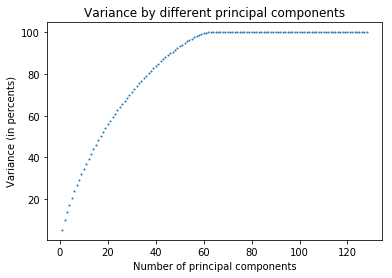

In [100]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

x_ = [i for i in range(1,129)]

plt.scatter(x=x_, y=cum_var_exp, s=1)
plt.title("Variance by different principal components")
plt.xlabel("Number of principal components")
plt.ylabel("Variance (in percents)")
plt.savefig('variance.png')

In [101]:
pca_matrix = eig_pairs[0][1].reshape(128, 1)
num_components = 50

for i in range(1, num_components):
    pca_matrix = np.hstack((pca_matrix,
                            eig_pairs[i][1].reshape(128, 1)))

In [102]:
pca_matrix.shape

(128, 50)

In [103]:
X_pca = X.dot(pca_matrix)

In [104]:
# Whitening
X_whit = X_pca / np.sqrt(eig_vals[:50])

Text(0,0.5,'w2')

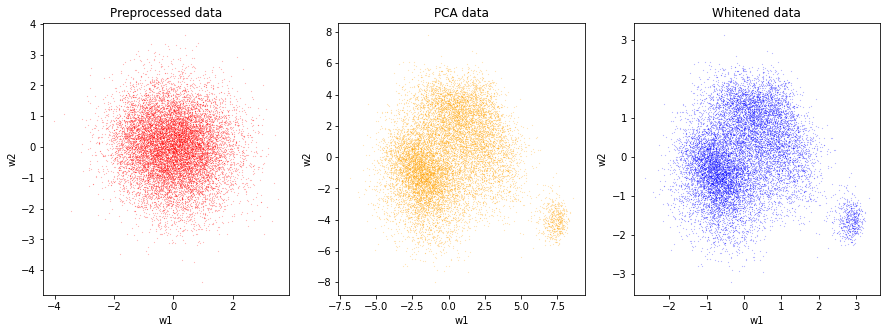

In [105]:
fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

# Original data
ax1.set_title("Preprocessed data")
ax1.scatter(X[:, w1], X[:, w2], c="red", s=s_)
ax1.set_xlabel("w1")
ax1.set_ylabel("w2")

# PCA data
ax2.set_title("PCA data")
ax2.scatter(X_pca[:, w1], X_pca[:, w2], c="orange", s=s_)
ax2.set_xlabel("w1")
ax2.set_ylabel("w2")

# Whitened data
ax3.set_title("Whitened data")
ax3.scatter(X_whit[:, w1], X_whit[:, w2], c="b", s=s_)
ax3.set_xlabel("w1")
ax3.set_ylabel("w2")

In [27]:
printData(train_labels, train_paths, 20)

  0   0   AJ_Cook_0001.png

  1   1   AJ_Lamas_0001.png

  2   2   Aaron_Eckhart_0001.png

  3   3   Aaron_Guiel_0001.png

  4   4   Aaron_Patterson_0001.png

  5   5   Aaron_Peirsol_0001.png
  6   5   Aaron_Peirsol_0002.png
  7   5   Aaron_Peirsol_0003.png
  8   5   Aaron_Peirsol_0004.png

  9   6   Aaron_Pena_0001.png

 10   7   Aaron_Sorkin_0001.png
 11   7   Aaron_Sorkin_0002.png

 12   8   Aaron_Tippin_0001.png

 13   9   Abba_Eban_0001.png

 14  10   Abbas_Kiarostami_0001.png

 15  11   Abdel_Aziz_Al-Hakim_0001.png

 16  12   Abdel_Madi_Shabneh_0001.png

 17  13   Abdel_Nasser_Assidi_0001.png
 18  13   Abdel_Nasser_Assidi_0002.png

 19  14   Abdoulaye_Wade_0001.png


In [28]:
X_work = np.delete(X_whit, (6, 7, 8), axis=0)

In [29]:
c, w = trainFisherWithNum(X_work, 5)

In [30]:
lng = len(X_whit)
summ = 0
thr = 0.7

for i in range(lng):
    l = Fisher(w, 0.0, X_whit[i]/np.linalg.norm(X_whit[i]))
    if l > thr and train_labels[i] == 5:
        summ += 1
    elif l <= thr and train_labels[i] != 5:
        summ += 1
    else:
        print(i, l, "(class: %d)"%train_labels[i])

print('')
print("Accuracy:", summ / lng)

8 0.58292861221 (class: 5)

Accuracy: 0.9999244313458777


In [33]:
v1 = np.array([2, 2])
v1 = v1 / np.linalg.norm(v1)

v2 = np.array([-2, -9])
v2 = v2 / np.linalg.norm(v2)

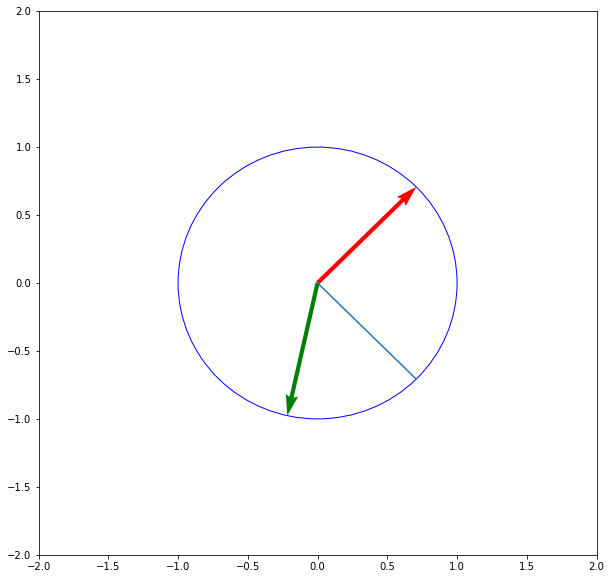

In [36]:
fig, ((ax1)) = plt.subplots(nrows=1, ncols=1, figsize=(10,10))

ax1.quiver(0, 0, [v1[0], v2[0]], [v1[1], v2[1]], angles='xy', scale_units='xy', scale=1, color=["red", "green"])
ax1.plot([0, v1[0]], [0, -v1[1]])
ax1.set_xlim([-2, 2])
ax1.set_ylim([-2, 2])

cr = plt.Circle((0, 0), 1, color='blue', fill=False)
ax1.add_artist(cr)

plt.show()

In [40]:
# Benchmark1

In [110]:
# y = kx + b
b_k = np.random.randn()
b_b = np.random.randn()
b_x_ = X_whit[:, w1]
b_y_ = b_k * b_x_ + b_b

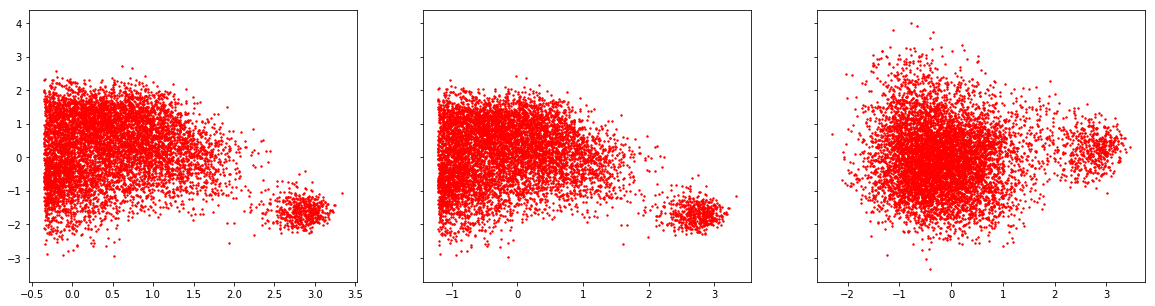

In [111]:
ge = np.greater_equal(X_whit[:, w1], b_y_) # ge = greater and equal

b_data_right = X_whit[ge]

b_train_labels = np.array(train_labels)
b_train_labels = b_train_labels[ge]

b_train_paths = np.array(train_paths)
b_train_paths = b_train_paths[ge]

fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(20, 5), sharey="row")
ax1.scatter(b_data_right[:, w1], b_data_right[:, w2], s=2, c="red")

b_data_right = b_data_right - b_data_right.mean(axis=0)
b_data_right = b_data_right / b_data_right.std(axis=0)
ax2.scatter(b_data_right[:, w1], b_data_right[:, w2], s=2, c="red")

pca = PCA(n_components=2, whiten=True)
pca.fit(b_data_right)
b_data_right = pca.transform(b_data_right)
ax3.scatter(b_data_right[:, w1], b_data_right[:, w2], s=2, c="red")

In [115]:
printData(b_train_labels, b_train_paths, 40)

  0   2   Aaron_Eckhart_0001.png

  1   3   Aaron_Guiel_0001.png

  2   5   Aaron_Peirsol_0001.png
  3   5   Aaron_Peirsol_0002.png
  4   5   Aaron_Peirsol_0003.png

  5   6   Aaron_Pena_0001.png

  6   8   Aaron_Tippin_0001.png

  7   9   Abba_Eban_0001.png

  8  10   Abbas_Kiarostami_0001.png

  9  12   Abdel_Madi_Shabneh_0001.png

 10  14   Abdoulaye_Wade_0001.png
 11  14   Abdoulaye_Wade_0003.png
 12  14   Abdoulaye_Wade_0004.png

 13  15   Abdul_Majeed_Shobokshi_0001.png

 14  17   Abdulaziz_Kamilov_0001.png

 15  19   Abdullah_Ahmad_Badawi_0001.png

 16  20   Abdullah_Gul_0001.png
 17  20   Abdullah_Gul_0002.png
 18  20   Abdullah_Gul_0003.png
 19  20   Abdullah_Gul_0005.png
 20  20   Abdullah_Gul_0006.png
 21  20   Abdullah_Gul_0007.png
 22  20   Abdullah_Gul_0010.png
 23  20   Abdullah_Gul_0011.png
 24  20   Abdullah_Gul_0012.png
 25  20   Abdullah_Gul_0013.png
 26  20   Abdullah_Gul_0014.png
 27  20   Abdullah_Gul_0015.png
 28  20   Abdullah_Gul_0016.png
 29  20   Abdullah_Gul

In [117]:
b_X_work = np.delete(b_data_right, (36, 37, 38), axis=0)
c, w = trainFisherWithNum(b_X_work, 35)

lng = len(b_data_right)
summ = 0
thr = 0.5

for i in range(lng):
    l = Fisher(w, 0.0, b_data_right[i]/np.linalg.norm(b_data_right[i]))
    if l > thr and b_train_labels[i] == 25:
        summ += 1
    elif l <= thr and b_train_labels[i] != 25:
        summ += 1
    else:
        print(i, l, "(class: %d)"%b_train_labels[i])

print('')
print("Accuracy:", summ / lng)

0 0.805490089895 (class: 2)
7 0.610600154832 (class: 9)
13 0.955096907269 (class: 15)
14 0.941076731946 (class: 17)
15 0.997542494385 (class: 19)
16 0.742476698143 (class: 20)
17 0.980507477992 (class: 20)
19 0.782994620881 (class: 20)
20 0.999109395179 (class: 20)
21 0.943043451059 (class: 20)
22 0.822170074616 (class: 20)
24 0.984566819957 (class: 20)
25 0.61360694224 (class: 20)
26 0.958675494539 (class: 20)
27 0.943795733703 (class: 20)
29 0.918546586313 (class: 20)
31 0.970393391767 (class: 22)
32 0.857115785868 (class: 22)
36 0.390463498049 (class: 25)
37 -0.0605394363813 (class: 25)
38 0.493589219697 (class: 25)
40 0.991203786345 (class: 26)
41 0.998721006286 (class: 26)
42 0.99325641321 (class: 28)
46 0.964314446483 (class: 41)
47 0.991311618393 (class: 41)
48 0.837989871926 (class: 42)
49 0.99876907112 (class: 43)
51 0.998784535804 (class: 48)
52 0.711294892929 (class: 57)
53 0.644615870529 (class: 61)
55 0.971986520344 (class: 65)
58 0.974866529425 (class: 70)
60 0.8593256046

873 0.576225610658 (class: 754)
874 0.971428740949 (class: 760)
878 0.999816966116 (class: 763)
879 0.99392228596 (class: 763)
880 0.981521551712 (class: 763)
881 0.963058798304 (class: 763)
883 0.991539503623 (class: 770)
885 0.805703918209 (class: 770)
890 0.839803979169 (class: 778)
892 0.82936730469 (class: 779)
894 0.870361698782 (class: 782)
897 0.781288490281 (class: 786)
899 0.969670241594 (class: 786)
901 0.891099196052 (class: 786)
903 0.99400269937 (class: 786)
905 0.967137272961 (class: 786)
907 0.999412983554 (class: 786)
908 0.747623157098 (class: 786)
909 0.900606245045 (class: 786)
912 0.998348528786 (class: 786)
913 0.976141653317 (class: 786)
914 0.738327444928 (class: 786)
915 0.947907599598 (class: 786)
916 0.846256474123 (class: 786)
917 0.905391831542 (class: 787)
918 0.909999156588 (class: 787)
926 0.554368804624 (class: 788)
934 0.686626740499 (class: 788)
939 0.941473755239 (class: 792)
940 0.714548540218 (class: 792)
941 0.6444847362 (class: 793)
947 0.9730440

2125 0.964933461947 (class: 1846)
2126 0.934504413239 (class: 1848)
2156 0.923439014757 (class: 1858)
2157 0.888039227087 (class: 1859)
2170 0.620298097292 (class: 1866)
2171 0.795122771621 (class: 1866)
2172 0.885611541722 (class: 1866)
2176 0.928404413399 (class: 1866)
2178 0.790747742092 (class: 1866)
2180 0.773846457885 (class: 1866)
2181 0.639151972185 (class: 1866)
2182 0.91270575463 (class: 1866)
2184 0.584800157708 (class: 1866)
2185 0.678020090209 (class: 1866)
2187 0.79797642623 (class: 1866)
2188 0.762078710857 (class: 1866)
2189 0.532968575056 (class: 1866)
2190 0.873857991742 (class: 1866)
2193 0.955958469574 (class: 1868)
2194 0.775861739671 (class: 1868)
2195 0.948972521159 (class: 1868)
2196 0.851772776213 (class: 1868)
2197 0.884270019107 (class: 1869)
2736 0.972670643499 (class: 1883)
2737 0.999937998776 (class: 1885)
2738 0.879448938484 (class: 1885)
2741 0.902376905249 (class: 1890)
2853 0.930395886393 (class: 1895)
2854 0.896841487331 (class: 1895)
2855 0.968515988

4569 0.987107443272 (class: 3071)
4571 0.754003408238 (class: 3078)
4572 0.788906208771 (class: 3086)
4584 0.994303288234 (class: 3094)
4585 0.586169820076 (class: 3099)
4597 0.833509838545 (class: 3101)
4599 0.9961154431 (class: 3103)
4600 0.997680832375 (class: 3103)
4601 0.992732795577 (class: 3103)
4607 0.961451462971 (class: 3110)
4608 0.999340901868 (class: 3111)
4616 0.981671094729 (class: 3123)
4620 0.962066619406 (class: 3127)
4621 0.981620130062 (class: 3127)
4622 0.772416880037 (class: 3127)
4623 0.98940860981 (class: 3127)
4624 0.999995488521 (class: 3127)
4625 0.999735587264 (class: 3127)
4626 0.977480370183 (class: 3127)
4627 0.994904816926 (class: 3127)
4628 0.960380718456 (class: 3127)
4629 0.999993902361 (class: 3127)
4630 0.968174071759 (class: 3127)
4631 0.954312418598 (class: 3127)
4632 0.99666643833 (class: 3127)
4633 0.998684825943 (class: 3127)
4634 0.951075954744 (class: 3127)
4635 0.962448545758 (class: 3127)
4636 0.940013098879 (class: 3127)
4637 0.99959867335

5775 0.780909153054 (class: 4290)
5777 0.538733953662 (class: 4290)
5781 0.963886637217 (class: 4290)
5787 0.877202344521 (class: 4296)
5788 0.882611586298 (class: 4303)
5789 0.762557170663 (class: 4303)
5790 0.832504887283 (class: 4304)
5791 0.893903080365 (class: 4304)
5793 0.544009295088 (class: 4304)
5794 0.990642479558 (class: 4304)
5795 0.862714544508 (class: 4304)
5796 0.833642782366 (class: 4304)
5799 0.991073924045 (class: 4308)
5800 0.999353846891 (class: 4308)
5801 0.98667522902 (class: 4308)
5802 0.997511821847 (class: 4308)
5803 0.678719697787 (class: 4311)
5804 0.979797085342 (class: 4311)
5805 0.659248326988 (class: 4311)
5806 0.990618909382 (class: 4311)
5807 0.943091339283 (class: 4315)
5810 0.931862887659 (class: 4321)
5813 0.999562394446 (class: 4327)
5814 0.992396364495 (class: 4327)
5815 0.969513700444 (class: 4327)
5816 0.994737728652 (class: 4327)
5817 0.883271165648 (class: 4327)
5818 0.999764023364 (class: 4327)
5819 0.96339457496 (class: 4327)
5820 0.969990974

In [109]:
b_data_right

array([], shape=(0, 50), dtype=float64)